# Full example

This example demonstrates the power of the `rapbro` interface to Google Earth Engine (GEE) to collect many subbasin attributes associated with multiple coordinate pairs.

In [1]:
import os
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt

import rabpro
from rabpro.subbasin_stats import Dataset

First let's create a list of coordinate pairs that we'll use to delineate our basins of interest. For this example, we'll retrieve the subbasins associated with dams in Sri Lanka.

In [2]:
vdams_srilanka = pd.read_csv("vote-dams_sri-lanka.csv")
coord_list = [
    (vdams_srilanka.iloc[i]["lat"], vdams_srilanka.iloc[i]["long"])
    for i in range(0, vdams_srilanka.shape[0])
]
vdams_srilanka.head()

wkt_geom  vote_id  grand_id  \
0  Point (80.32409599999999728 9.29935200000000073)    13331         0   
1  Point (81.01001970000000085 6.91596489999999964)    13332         0   
2  Point (80.22376599999999769 8.17094239999999949)    13333         0   
3  Point (80.38527779999999723 8.35194440000000071)    13334         0   
4  Point (80.58550379999999791 6.85771860000000011)    13335         0   

   geodar_id_v10  geodar_id_v11  nid_id  nid_otherstructure  eha_pid  \
0           4016          13456     NaN                 NaN      NaN   
1           4017          13457     NaN                 NaN      NaN   
2           4018          13458     NaN                 NaN      NaN   
3           4019          13459     NaN                 NaN      NaN   
4           4020          13460     NaN                 NaN      NaN   

        long       lat  source                                     geom_all  
0  80.324096  9.299352  geodar  POINT (80.32409600000005 9.299352000000056)  
1  81.010020  6.915965  geodar  POINT (81.01001970000004 6.915964900000063)  
2  80.223766  8.170942  geodar  POINT (80.22376600000007 8.170942400000058)  
3  80.385278  8.351944  geodar  POINT (80.38527780000005 8.351944400000036)  
4  80.585504  6.857719  geodar   POINT (80.5855038000001 6.857718600000055)

In [3]:
if not os.path.exists("basins_sl.gpkg"):
    basins_sl = []
    for i in range(0, len(coord_list)):
        print(i)
        rpo = rabpro.profiler(coord_list[i], force_merit=True, verbose=False)
        rpo.delineate_basins()
        basins_sl.append(rpo.basins)

    basins_sl = pd.concat(basins_sl)
    basins_sl.to_file("basins_sl.gpkg", driver="GPKG")
else:
    basins_sl = gpd.read_file("basins_sl.gpkg")

We need to upload our basin vector layer as a GEE asset because it too large to send as a json payload. This can be done manually through the GEE code editor or via `rabpro` automation. This automation requires that you have a writeable Google Cloud Platform (GCP) bucket and that you are authenticated via the command-line to call the `gsutil` and `earthengine` programs. These programs enable sending files to GCP and onward to GEE respectively.

```python
gcp_bucket = "your_gcp_bucket"
gee_user = "your_gee_username"
zip_path = rabpro.utils.build_gee_vector_asset(basins_sl, "basins_sl.zip")
your_gee_asset = rabpro.utils.upload_gee_vector_asset(
    zip_path, gee_user, gcp_bucket, gcp_folder="rabpro"
)

```

Next let's define a list of Google Earth Engine (GEE) datasets to intersect with our delineated basins:

In [4]:
dataset_list = [
    Dataset(
        "JRC/GSW1_3/GlobalSurfaceWater",
        "occurrence",
        time_stats=["median"],
        stats=["mean"],
    ),
    Dataset(
        "ECMWF/ERA5_LAND/MONTHLY",
        "temperature_2m",
        time_stats=["median"],
        stats=["mean"],
    ),
    Dataset(
        "UCSB-CHG/CHIRPS/DAILY", "precipitation", time_stats=["median"], stats=["mean"]
    ),
]

Now let's do the intersection with `rabpro.subbasin_stats.compute`, format the results, and join it to our basins GeoDataFrame.

In [5]:
your_gee_asset = 'users/jstacompute/basins_sl'

In [6]:
if not os.path.exists("res.gpkg"):
    urls, tasks = rabpro.subbasin_stats.compute(
        dataset_list, gee_feature_path=your_gee_asset, folder="rabpro"
    )
    tag_list = ["wateroccur", "temperature_2m", "precip"]
    data = rabpro.subbasin_stats.format_gee(urls, tag_list)

    res = gpd.GeoDataFrame(pd.concat([data, basins_sl], axis=1))
    res = res.set_geometry("geometry")
    res.to_file("res.gpkg", driver="GPKG")
else:
    res = gpd.read_file("res.gpkg")

Finally, a visualization!

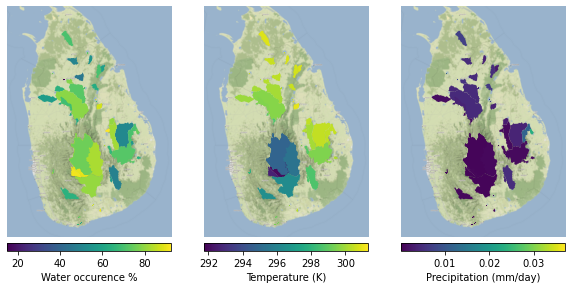

In [7]:
def build_panel(col_name, col_label, axis):
    axis.set_xlim([left-0.5, right+0.5])
    axis.set_ylim([bot-0.2, top+0.2])
    axis.set_axis_off()
    res.plot(
        ax=axis,
        column=col_name,
        legend=True,
        legend_kwds={"label": col_label, "orientation": "horizontal", "pad": 0.01},
    )    
    cx.add_basemap(axis, zoom=10, crs=res.crs, attribution="")
    return axis


left, bot, right, top = res.total_bounds
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax = [
    build_panel(col_name, col_label, ax[i])
    for col_name, col_label, i in zip(
        [x for x in res.columns[0:3]],
        ["Water occurence %", "Temperature (K)", "Precipitation (mm/day)"],
        range(0, 3),
    )
]